In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets,models,transforms
import os
import numpy as np
from torch.autograd import Variable

/home/sumit/anaconda3/envs/torch_gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Augmentation

In [2]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

In [3]:
data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size = 4, shuffle = True) for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes


# print the results
print(f"Class Names : {class_names}")
print(f"There are {len(dataloaders['train'])} batches in the train set")
print(f"There are {len(dataloaders['val'])} batches in test set")
print(f"There are {dataset_sizes['train']} training images")
print(f"There are {dataset_sizes['val']} testing images")

Class Names : ['ants', 'bees']
There are 61 batches in the train set
There are 39 batches in test set
There are 244 training images
There are 153 testing images


In [4]:
## Load the resnet

model_conv = torchvision.models.resnet18(pretrained=True)

/home/sumit/anaconda3/envs/torch_gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sumit/anaconda3/envs/torch_gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Freeze all the layers in the network
for param in model_conv.parameters():

    param.requires_grad = False

In [6]:
# Get the number of imputs of the last layer(or number of neurons in the layer preceeding the last layer)
num_ftrs = model_conv.fc.in_features
# Reconstruct the last layer (output layer) to have only two classes
model_conv.fc = nn.Linear(num_ftrs,2)


In [7]:
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [8]:
# Understand what's happening
iteration = 0
correct = 0

for inputs,labels in dataloaders['train']:
    if iteration ==1:
        break
        
    inputs = Variable(inputs)
    labels = Variable(labels)
    
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    print("For one iteration, this is what happens:")
    print("Input shape:",inputs.shape)
    print("labels shape:",labels.shape)
    print("labels are:{}".format(labels))
    # Forward propogation
    output = model_conv(inputs)
    print("Output Tensor:",output)
    print("Outputs shape",output.shape)
    _,predicted = torch.max(output,1)
    print("predicted:",predicted)
    print("predicted shape",predicted.shape)
    correct += (predicted == labels).sum()
    print("Correct predictions:",correct)
    
    iteration +=1 
    

For one iteration, this is what happens:
Input shape: torch.Size([4, 3, 224, 224])
labels shape: torch.Size([4])
labels are:tensor([1, 1, 1, 0], device='cuda:0')
Output Tensor: tensor([[ 0.0057, -0.3618],
        [ 0.1111,  0.1690],
        [-0.3349,  0.3580],
        [ 0.5265, -0.5908]], device='cuda:0', grad_fn=<AddmmBackward0>)
Outputs shape torch.Size([4, 2])
predicted: tensor([0, 1, 1, 0], device='cuda:0')
predicted shape torch.Size([4])
Correct predictions: tensor(3, device='cuda:0')


- In the above Input shape: torch.Size([4, 3, 224, 224])
- 3 is the number of channels. 4 is the batch size


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(),lr = 0.001, momentum=0.9)

# Try experimenting with optim.Adam(model_conv.fc.parameters(),lr = 0.001)
# Decay LR by as factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=8,gamma=0.1)

In [10]:
num_epochs = 25
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    # Reset the correct to 0 after passing through all the dataset
    correct = 0
    
    for images,labels in dataloaders['train']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
            
        optimizer.zero_grad()
        outputs = model_conv(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        _,predicted = torch.max(outputs,1)
        correct += (predicted == labels).sum()
        
        
    train_acc = 100 * correct / dataset_sizes['train']
    
    print('Epoch [{}/{}],Loss:{:.4f},Train Accuracy:{}%'.format(epoch+1,num_epochs,loss.item(),train_acc))

/home/sumit/anaconda3/envs/torch_gpu/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/25],Loss:1.6769,Train Accuracy:72.13114166259766%
Epoch [2/25],Loss:0.6708,Train Accuracy:81.14753723144531%
Epoch [3/25],Loss:0.0935,Train Accuracy:80.73770141601562%
Epoch [4/25],Loss:2.7676,Train Accuracy:76.63934326171875%
Epoch [5/25],Loss:0.7038,Train Accuracy:79.91802978515625%
Epoch [6/25],Loss:0.7670,Train Accuracy:77.45901489257812%
Epoch [7/25],Loss:0.7451,Train Accuracy:75.40982818603516%
Epoch [8/25],Loss:0.0717,Train Accuracy:84.01638793945312%
Epoch [9/25],Loss:0.5081,Train Accuracy:81.96720886230469%
Epoch [10/25],Loss:1.1917,Train Accuracy:85.24589538574219%
Epoch [11/25],Loss:0.0185,Train Accuracy:84.01638793945312%
Epoch [12/25],Loss:0.4931,Train Accuracy:86.47540283203125%
Epoch [13/25],Loss:0.0656,Train Accuracy:87.29507446289062%
Epoch [14/25],Loss:0.1264,Train Accuracy:83.19671630859375%
Epoch [15/25],Loss:0.1321,Train Accuracy:86.06556701660156%
Epoch [16/25],Loss:0.2613,Train Accuracy:86.88523864746094%
Epoch [17/25],Loss:0.1385,Train Accuracy:84.42622

In [12]:
### Test the model

model_conv.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for (images,labels) in dataloaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        outputs = model_conv(images)
        _,predicted = torch.max(outputs.data,1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy: {:.3f} %'.format(100 * correct/total))

Test Accuracy: 92.810 %


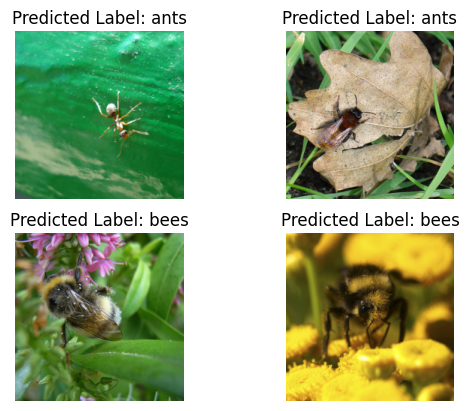

In [14]:
#Visualize some predictions 
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in dataloaders['val']:
        if shown_batch == 1:
            break
        shown_batch += 1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)                            #The output is of shape (4,2)
        _, preds = torch.max(outputs, 1)                        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            input_img = images.cpu().data[i]                    #Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            ## Now Denormalizing
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])1WJ
            ## Formula for denormalizing
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 27.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 39.2 MB/s eta 0:00:00


In [42]:
import pandas as pd
k = {0:[[1,2,3,4,5]],2:[[5,6,7,8,9]],3:[[10,19,19,39,38]]}

In [43]:
# pd.Series(k)

In [35]:
m = k[0]

In [38]:
df = pd.DataFrame.from_dict(k[1:],orient='index')
df

TypeError: unhashable type: 'slice'

In [39]:
data = [['Name','Rank','Complete'],
   ...:                ['one', 1, 1],
   ...:                ['two', 2, 1],
   ...:                ['three', 3, 1],
   ...:                ['four', 4, 1],
   ...:                ['five', 5, 1]]

In [40]:
df = pd.DataFrame(data[1:],columns=data[0])

In [41]:
df

,Name,Rank,Complete
0,one,1,1
1,two,2,1
2,three,3,1
3,four,4,1
4,five,5,1
